In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

In [5]:
# pulling data from Codeup Data Science MySQL Server
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'

query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''
df0 = pd.read_sql(query, url)

In [6]:
# making a copy of the pulled dataframe to be used during the rest of the exercise
df = df0.copy()

In [7]:
# converting the dataframe to a csv file for future use
df.to_csv('curriculum_csv')

In [8]:
# converting the date values from objects to datetimes
df.date = df.date.astype('datetime64')
# setting the date column as the index
df = df.set_index('date')

In [10]:
# grouping by the endpoint column to see how many times a page receives a hit/is accessed each day
hits = df.endpoint.resample('D').count()
hits.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [13]:
# creating a 7 day Exponential Moving Average (EMA)
ema_7d = hits.ewm(span=7).mean()

# creating a 14 day EMA
ema_14d = hits.ewm(span=14).mean()

# creating a 30 day EMA
ema_30d = hits.ewm(span=30).mean()

# creating a 90 day EMA
ema_90d = hits.ewm(span=90).mean()
ema_90d

date
2018-01-26     572.000000
2018-01-27     399.100000
2018-01-28     321.030081
2018-01-29     452.545042
2018-01-30     494.228442
                 ...     
2021-04-17    1192.041636
2021-04-18    1180.326435
2021-04-19    1201.769810
2021-04-20    1217.774869
2021-04-21    1215.867729
Freq: D, Name: endpoint, Length: 1182, dtype: float64

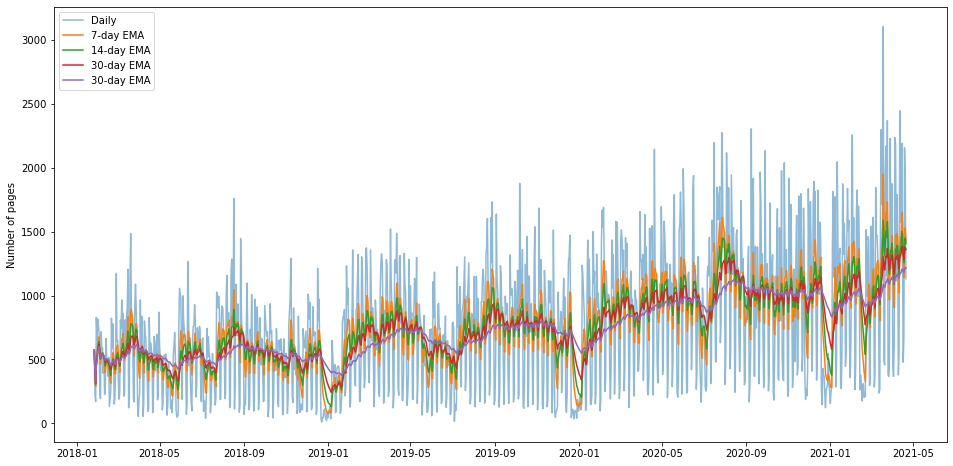

In [14]:
# plotting each span of time used for the EMA
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(hits.index, hits, label='Daily', alpha=.5)

ax.plot(hits.index, ema_7d, label = '7-day EMA')
ax.plot(hits.index, ema_14d, label = '14-day EMA')
ax.plot(hits.index, ema_30d, label = '30-day EMA')
ax.plot(hits.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


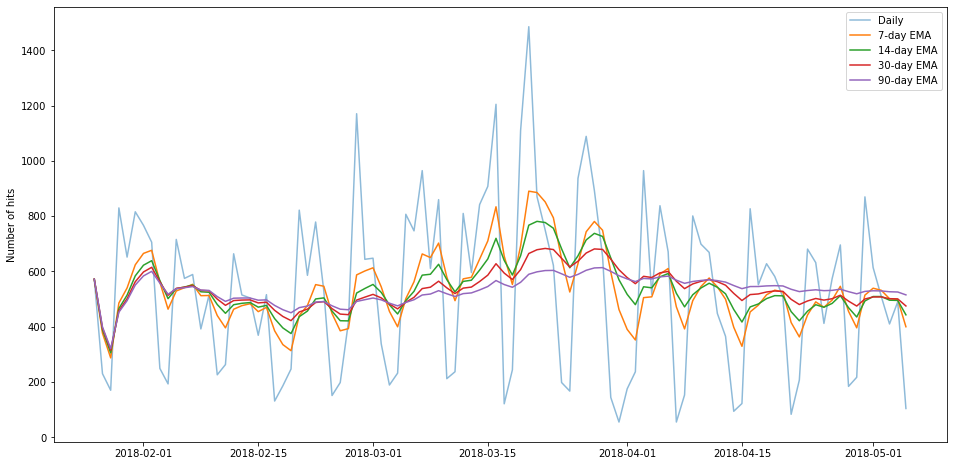

In [20]:
# Plotting the same information but condensing the visual down to a span of 100 days for each EMA
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(hits.index[:100], hits[:100], label='Daily', alpha=.5)
ax.plot(hits.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(hits.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(hits.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(hits.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of hits')

plt.show()

In [16]:
# set the window span
span = 30

# compute midband
midband = hits.ewm(span=span).mean()

# compute exponential stdev
stdev = hits.ewm(span=span).std()

# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [17]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub,lb],axis=1) 
bb.columns = ['ub','lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [19]:
# add to hits df
my_df = pd.concat([hits,midband,bb],axis=1)
my_df.columns = ['hits','midband','ub','lb']
my_df.head()

,hits,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


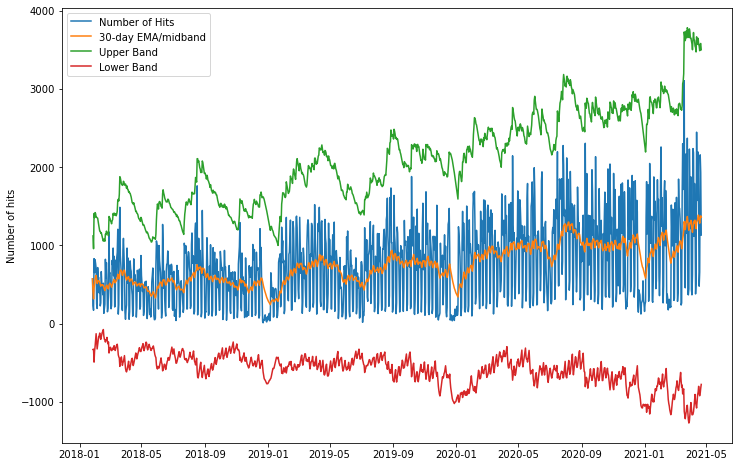

In [22]:
# plotting the bollinger bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.hits, label='Number of Hits')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of hits')

plt.show()

In [23]:
# calculate the percent bandwidth of each row and create a column to hold the values
my_df['pct_b'] = (my_df.hits - my_df.lb) / (my_df.ub - my_df.lb)
my_df.head()

,hits,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [25]:
# creating a function to pull data from Codeup Database
def acquire_logs(user=env.username, password=env.password, host=env.host):
    '''
    Parameters:  Your username, password, and host that should be located in you env.py
    
    Returns: curriculum_logs dataframe
    '''
    
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [69]:
# 
def prep(df, user):
    '''
    Parameters:
    
    Returns:
    '''
    
    df = df[df.user_id == user].copy()
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    hits = df['endpoint'].resample('d').count()
    return hits

In [70]:
# 
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    Parameters:
    
    Returns:
    '''
    
    midband = hits.ewm(span=span).mean()
    stdev = hits.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    bb = pd.concat([ub, lb], axis=1)
    
    my_df = pd.concat([hits, midband, bb], axis=1)
    my_df.columns = ['hits', 'midband', 'ub', 'lb']
    
    my_df['pct_b'] = (my_df['hits'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [71]:
# 
def plot_bands(my_df, user):
    '''
    Parameters:
    
    Returns:
    '''
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.hits, label='Number of hits, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of hits')
    plt.show()

In [26]:
# ties all of the other functions together to discover if a user has any out of normal behavior
def find_anomalies(df, user, span, weight, plot=False):
    '''
    Parameters: 
    df = dataframe
    user = user_id you want to analyze
    span = n, window span of time
    weight = n, the level of stdev you want to be away from the average
    
    Returns: a dataframe with every anomaly detected per your parameters
    '''
    
    hits = prep(df, user)
    
    my_df = compute_pct_b(hits, span, weight, user)
    
    if plot:
        plot_bands(my_df, user)
    
    return my_df[my_df.pct_b>1]